In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

In [ ]:
datos = pd.read_csv(r'C:\Users\miche\diabetes.csv', low_memory=False)

In [ ]:
print(datos.head())
print(datos.info())
print(datos.isnull().sum())  

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

In [ ]:
X = datos.drop(columns=['Outcome'])
y = datos['Outcome']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
modelo = DecisionTreeClassifier(random_state=42)
modelo.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = modelo.predict(X_test_scaled)
print("Accuracy inicial:", accuracy_score(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Accuracy inicial: 0.7467532467532467
Matriz de confusión:
 [[75 24]
 [15 40]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79        99
           1       0.62      0.73      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



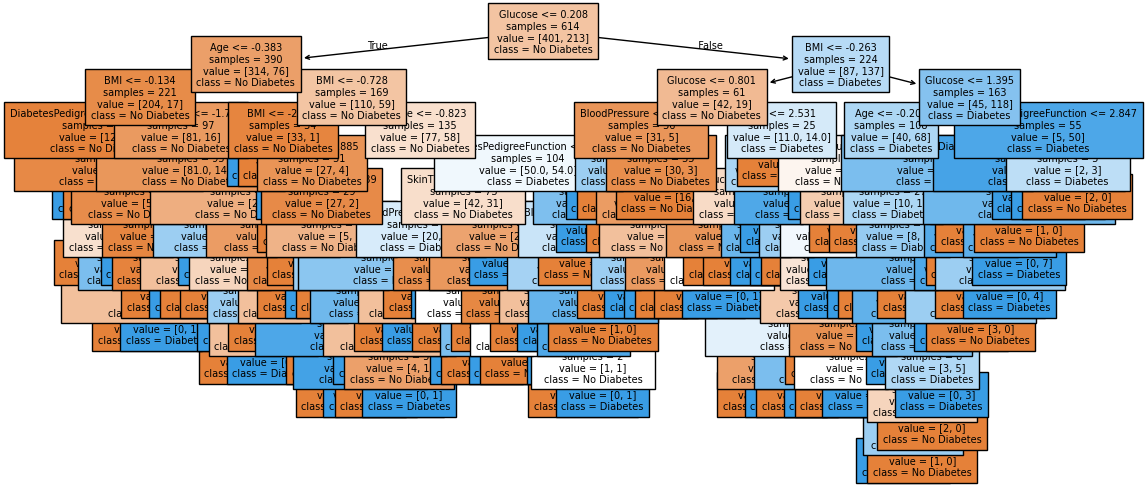

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))
plot_tree(modelo, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True, impurity=False, fontsize=7, ax=ax)
plt.show()


In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_leaf': [3, 5, 10, 15, 20],
    'min_samples_split': [8, 10, 12, 18, 20]
}


In [54]:
search = GridSearchCV(modelo, param_grid, scoring='accuracy', n_jobs=-1, cv=cv)
search.fit(X_train_scaled, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, 15],
                         'min_samples_leaf': [3, 5, 10, 15, 20],
                         'min_samples_split': [8, 10, 12, 18, 20]},
             scoring='accuracy')

In [ ]:
print("Mejor Accuracy:", search.best_score_)
print("Mejores Hiperparámetros:", search.best_params_)


Mejor Accuracy: 0.7677331218050413
Mejores Hiperparámetros: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 8}


In [ ]:
modelo_optimizado = DecisionTreeClassifier(**search.best_params_, random_state=42)
modelo_optimizado.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=20,
                       min_samples_split=8, random_state=42)

In [ ]:
y_pred_opt = modelo_optimizado.predict(X_test_scaled)
print("Accuracy optimizado:", accuracy_score(y_test, y_pred_opt))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_opt))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_opt))

Accuracy optimizado: 0.7597402597402597
Matriz de confusión:
 [[76 23]
 [14 41]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80        99
           1       0.64      0.75      0.69        55

    accuracy                           0.76       154
   macro avg       0.74      0.76      0.75       154
weighted avg       0.77      0.76      0.76       154



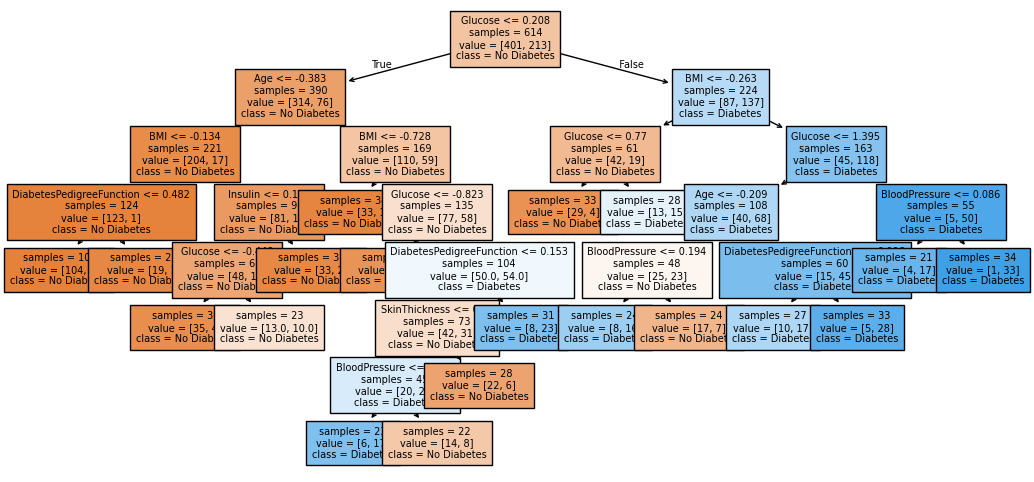

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))
plot_tree(modelo_optimizado, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True, impurity=False, fontsize=7, ax=ax)
plt.show()

In [ ]:
nuevo_dato = np.array([[3, 120, 70, 25, 150, 30.0, 0.5, 35]])  
nuevo_dato_scaled = scaler.transform(nuevo_dato)
prediccion = modelo_optimizado.predict(nuevo_dato_scaled)

if prediccion[0] == 1:
    print("La persona tiene diabetes.")
else:
    print("La persona no tiene diabetes.")

In [ ]:
fpr, tpr, _ = roc_curve(y_test, modelo_optimizado.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

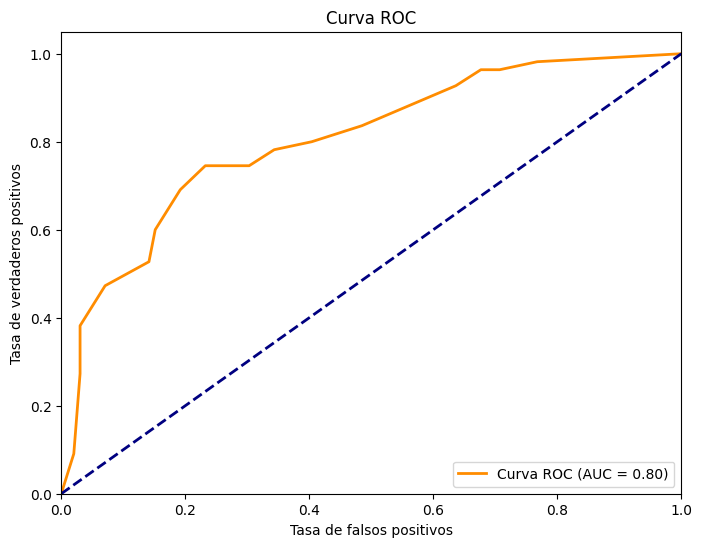

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, modelo_optimizado.predict_proba(X_test_scaled)[:, 1])


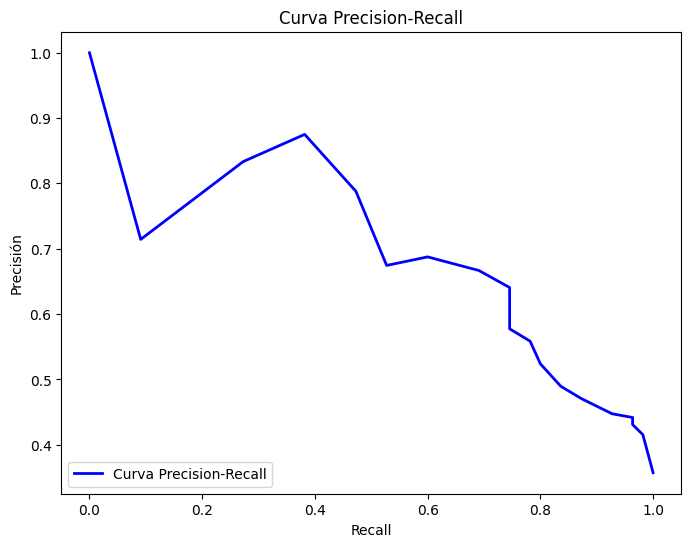

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva Precision-Recall')
plt.legend(loc='lower left')
plt.show()